<a href="https://colab.research.google.com/github/tombrash/handson-ml2/blob/master/workbooks/ch14/mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom CNN to process MNIST database

### Imports for model



In [1]:
# Key imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import time

### Importing and viewing dataset

In [2]:
ds, info = tfds.load('mnist', as_supervised=True, with_info=True, shuffle_files=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [39]:
# Split into train, validation, and test sets

train_unprocessed = ds['train'].skip(10000)
val_unprocessed = ds['train'].take(10000)
test_unprocessed = ds['test']

In [47]:
batch_size = 32
train_set = train_unprocessed.shuffle(1000)
train_set = train_set.batch(batch_size, drop_remainder=True) \
  .map(lambda img, label: (tf.image.convert_image_dtype(img, dtype=tf.float32), label)) \
  .prefetch(1)

val_set = val_unprocessed.batch(batch_size) \
  .map(lambda img, label: (tf.image.convert_image_dtype(img, dtype=tf.float32), label)) \
  .prefetch(1)

test_set = test_unprocessed.batch(batch_size) \
  .map(lambda img, label: (tf.image.convert_image_dtype(img, dtype=tf.float32), label)) \
  .prefetch(1)

In [48]:
# Visualize data
def visualize_data(n):
  fig = plt.figure(figsize=(8,8))

  img_generator = tfds.as_numpy(train_unprocessed.take(n ** 2))

  for i in range(1, n ** 2 + 1):
    img = next(img_generator)[0]
    fig.add_subplot(n,n,i)
    plt.imshow(img.squeeze(), cmap='Greys')
    plt.tick_params(axis='both', which='both',
      bottom=False, labelbottom=False,
      left=False, labelleft=False
  )

In [45]:
img_generator = tfds.as_numpy(train_set.take(1))
img = next(img_generator)[0]
img.max()

255

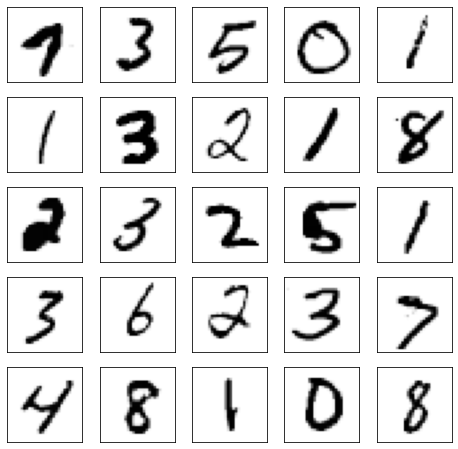

In [42]:
visualize_data(5)

### 1) A quick CNN model

Firstly we'll try using a very basic CNN model with just two Conv2D layers and a pooling layer. Hopefully this will provide a good baseline for what a convolutional neural network can do with the MNIST dataset

In [8]:
keras.backend.clear_session()
model = keras.Sequential([
          layers.Conv2D(32, 7, padding='SAME', input_shape=[28, 28, 1],
                        activation='relu'),
          layers.Conv2D(64, 7, padding='SAME', input_shape=[28, 28, 1],
                        activation='relu'),             
          layers.MaxPooling2D(2),
          layers.Flatten(),
          layers.Dense(128, activation='relu'),
          layers.Dropout(0.25),
          layers.Dense(64, activation='relu'),
          layers.Dropout(0.5),
          layers.Dense(10, activation='softmax'),
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        1600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        100416    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [10]:
model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [11]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_model.h5')
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
callbacks = [checkpoint_cb, earlystopping_cb]

In [12]:
history = model.fit(train_set, epochs=30, callbacks=callbacks, validation_data=val_set)

Epoch 1/30
1562/1562 [==============================] - 30s 19ms/step - loss: 0.4420 - accuracy: 0.8990 - val_loss: 0.1432 - val_accuracy: 0.9602
Epoch 2/30
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1444 - accuracy: 0.9646 - val_loss: 0.0713 - val_accuracy: 0.9842
Epoch 3/30
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1154 - accuracy: 0.9724 - val_loss: 0.0914 - val_accuracy: 0.9814
Epoch 4/30
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1027 - accuracy: 0.9759 - val_loss: 0.0764 - val_accuracy: 0.9850
Epoch 5/30
1562/1562 [==============================] - 29s 19ms/step - loss: 0.0858 - accuracy: 0.9786 - val_loss: 0.0845 - val_accuracy: 0.9817
Epoch 6/30
1562/1562 [==============================] - 29s 19ms/step - loss: 0.0748 - accuracy: 0.9822 - val_loss: 0.0786 - val_accuracy: 0.9844
Epoch 7/30
1562/1562 [==============================] - 29s 19ms/step - loss: 0.0713 - accuracy: 0.9828 - val_loss: 0.0624 -

In [13]:
predictions = model.evaluate(test_set)

313/313 [==============================] - 3s 10ms/step - loss: 0.0582 - accuracy: 0.9884


Pretty good! An accuracy of ~98.8%

### 2) A more sophisticated model

Next, we'll try using a more complicated CNN architecture, but still using the basic building blocks (Conv2D layers and max pooling layers followed by a couple of fully connected layers and a softmax output)

In [14]:
keras.backend.clear_session()
model_2 = keras.Sequential([
          layers.Conv2D(32, 7, padding='SAME', input_shape=[28, 28, 1],
                        activation='relu'),
          layers.Conv2D(64, 5, padding='SAME', input_shape=[28, 28, 1],
                        activation='relu'),             
          layers.MaxPooling2D(2),
          layers.Conv2D(128, 3, activation='relu', padding = 'SAME'),
          layers.Conv2D(128, 3, activation='relu', padding = 'SAME'),
          layers.MaxPooling2D(2),
          layers.Conv2D(256, 3, activation='relu', padding = 'SAME'),
          layers.Conv2D(256, 3, activation='relu', padding = 'SAME'),
          layers.MaxPooling2D(2),
          layers.Flatten(),
          layers.Dense(128, activation='relu'),
          layers.Dropout(0.25),
          layers.Dense(64, activation='relu'),
          layers.Dropout(0.5),
          layers.Dense(10, activation='softmax'),
])

In [28]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        1600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         2

In [23]:
model_2.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_model_2.h5')
earlystopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
callbacks = [checkpoint_cb, earlystopping_cb]

In [29]:
model_2.fit(train_set, epochs=20, callbacks=callbacks, validation_data=val_set)

Epoch 1/20
   9/1562 [..............................] - ETA: 48s - loss: 0.0759 - accuracy: 0.9757

KeyboardInterrupt: ignored

In [27]:
model.evaluate(test_set)

313/313 [==============================] - 3s 10ms/step - loss: 0.0654 - accuracy: 0.9868


[0.06542754918336868, 0.9868000149726868]

A setp in the wrong direction. Accuracy of 98.7% is actually worse than the simpler model, likely due to some overfitting of a small dataset

### 3) Smaller filters early on in the model

In [49]:
keras.backend.clear_session()
model_3 = keras.Sequential([
          layers.Conv2D(32, 3, padding='SAME', input_shape=[28, 28, 1],
                        activation='relu'),
          layers.Conv2D(64, 3, padding='SAME', input_shape=[28, 28, 1],
                        activation='relu'),             
          layers.MaxPooling2D(2),
          layers.Flatten(),
          layers.Dropout(0.25),
          layers.Dense(128, activation='relu'),
          layers.Dropout(0.25),
          layers.Dense(64, activation='relu'),
          layers.Dropout(0.5),
          layers.Dense(10, activation='softmax'),
])

In [50]:
model_3.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [51]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_model_3.h5')
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
callbacks = [checkpoint_cb, earlystopping_cb]

In [52]:
model_3.fit(train_set, epochs=30, callbacks=callbacks, validation_data=val_set)

Epoch 1/30
1562/1562 [==============================] - 24s 15ms/step - loss: 0.2819 - accuracy: 0.9166 - val_loss: 0.0666 - val_accuracy: 0.9813
Epoch 2/30
1562/1562 [==============================] - 24s 15ms/step - loss: 0.1028 - accuracy: 0.9727 - val_loss: 0.0596 - val_accuracy: 0.9846
Epoch 3/30
1562/1562 [==============================] - 23s 15ms/step - loss: 0.0760 - accuracy: 0.9801 - val_loss: 0.0499 - val_accuracy: 0.9872
Epoch 4/30
1562/1562 [==============================] - 24s 15ms/step - loss: 0.0589 - accuracy: 0.9845 - val_loss: 0.0623 - val_accuracy: 0.9856
Epoch 5/30
1562/1562 [==============================] - 23s 15ms/step - loss: 0.0506 - accuracy: 0.9864 - val_loss: 0.0598 - val_accuracy: 0.9865
Epoch 6/30
1562/1562 [==============================] - 24s 15ms/step - loss: 0.0415 - accuracy: 0.9886 - val_loss: 0.0573 - val_accuracy: 0.9875
Epoch 7/30
1562/1562 [==============================] - 23s 15ms/step - loss: 0.0385 - accuracy: 0.9898 - val_loss: 0.0530 -

In [53]:
model_3.evaluate(test_set)

313/313 [==============================] - 3s 11ms/step - loss: 0.0373 - accuracy: 0.9885


[0.03730719909071922, 0.9884999990463257]